<a href="https://colab.research.google.com/github/JahnaviSinha/OPEN-CV-Project/blob/main/ExpiryDateDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision opencv-python albumentations pytorch-lightning


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 38.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%cd /content
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

/content


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 24.4 MB/s eta 0:00:00


In [ ]:
!kaggle datasets download -d saket2008/expiry-date-dataset

Dataset URL: https://www.kaggle.com/datasets/saket2008/expiry-date-dataset
License(s): unknown
100% 3.62G/3.63G [00:56<00:00, 71.7MB/s]
100% 3.63G/3.63G [00:56<00:00, 68.5MB/s]


In [ ]:
!rm -rf Expiry-Date-Dataset

In [ ]:
!unzip -q expiry-date-dataset.zip -d ./Expiry-Date-Dataset

In [ ]:
import os

# Example filename
filenames = os.listdir("/content/Expiry-Date-Dataset")
# print(filenames)

print(len(filenames))

1


In [ ]:
import json
import os

dataset_dir = '/content/Expiry-Date-Dataset'

subfolders = ["Components_Real", "Components_Synth", "Date_Real", "Date_Synth", "Products_Synth"]

for folder in subfolders:
    annotations_path = os.path.join(dataset_dir, folder, '/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Components-Real/Components-Real/annotations.json')
    with open(annotations_path, 'r') as f:
        annotations = json.load(f)
    print(f"Annotations for {folder}:")
    print(json.dumps(annotations, indent=4))
    break  # Print the first folder's content


Annotations for Components_Real:
{
    "img_000000.jpg": {
        "height": 31,
        "width": 60,
        "transcription": "2021"
    },
    "img_000001.jpg": {
        "height": 32,
        "width": 34,
        "transcription": "05"
    },
    "img_000002.jpg": {
        "height": 31,
        "width": 32,
        "transcription": "23"
    },
    "img_000003.jpg": {
        "height": 19,
        "width": 62,
        "transcription": "2021"
    },
    "img_000004.jpg": {
        "height": 19,
        "width": 31,
        "transcription": "05"
    },
    "img_000005.jpg": {
        "height": 19,
        "width": 29,
        "transcription": "16"
    },
    "img_000006.jpg": {
        "height": 24,
        "width": 69,
        "transcription": "2022"
    },
    "img_000007.jpg": {
        "height": 24,
        "width": 37,
        "transcription": "09"
    },
    "img_000008.jpg": {
        "height": 24,
        "width": 33,
        "transcription": "10"
    },
    "img_000009.jpg": {

In [ ]:
import os

path = '/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Date-Real'
print("Files in the directory:", os.listdir(path))


dataset_dir = '/content/Expiry-Date-Dataset'
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file == 'annotations.json':
            print("Found:", os.path.join(root, file))

Files in the directory: ['Date-Real']
Found: /content/Expiry-Date-Dataset/Expiry_Date_Dataset/Date-Real/Date-Real/annotations.json
Found: /content/Expiry-Date-Dataset/Expiry_Date_Dataset/Components-Real/Components-Real/annotations.json
Found: /content/Expiry-Date-Dataset/Expiry_Date_Dataset/Products-Synth/Products-Synth/annotations.json
Found: /content/Expiry-Date-Dataset/Expiry_Date_Dataset/Components-Synth/Components-Synth/annotations.json
Found: /content/Expiry-Date-Dataset/Expiry_Date_Dataset/Date-Synth/Date-Synth/annotations.json


##Date Detection

In [ ]:
!rm -rf Date-Detection
import os
import json
import shutil
from sklearn.model_selection import train_test_split

# Paths
annotations_path = '/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Products-Synth/Products-Synth/annotations.json'
dataset_root = '/content/Date-Detection'
train_folder = os.path.join(dataset_root, 'train')
test_folder = os.path.join(dataset_root, 'test')

# Create necessary folders
for folder in [train_folder, test_folder]:
    os.makedirs(os.path.join(folder, 'images'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'labels'), exist_ok=True)

# Class Mapping
class_mapping = {
    'code': 0,
    'date': 1,
    'due': 2,
    'prod': 3
}

# Load annotations
with open(annotations_path, 'r') as f:
    annotations = json.load(f)

# Prepare data
image_data = []
for item in annotations.items():
    img_name = item[0]  # Image name
    img_info = item[1]  # Contains height, width, and ann
    image_data.append((img_name, img_info))

# Split into train and test sets
train_data, test_data = train_test_split(image_data, test_size=0.2, random_state=42)

def process_data(data, folder):
    for img_name, img_info in data:
        img_path = f"/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Products-Synth/Products-Synth/images/{img_name}"
        height, width = img_info['height'], img_info['width']
        label_path = os.path.join(folder, 'labels', img_name.replace('.jpg', '.txt'))

        # Copy image to the corresponding images folder
        shutil.copy(img_path, os.path.join(folder, 'images', img_name))

        # Create label file
        with open(label_path, 'w') as label_file:
            for ann in img_info['ann']:
                cls = ann['cls']
                bbox = ann['bbox']

                # Normalize bbox coordinates
                x_center = ((bbox[0] + bbox[2]) / 2) / width
                y_center = ((bbox[1] + bbox[3]) / 2) / height
                box_width = (bbox[2] - bbox[0]) / width
                box_height = (bbox[3] - bbox[1]) / height

                # Get class ID
                class_id = class_mapping.get(cls, -1)  # Default to -1 if class not found
                if class_id == -1:
                    continue  # Skip unknown classes

                # Write YOLOv8 label format
                label_file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}\n")

# Process train and test data
process_data(train_data, train_folder)
process_data(test_data, test_folder)

print("Dataset preparation complete!")


Dataset preparation complete!


###Make YAML File

In [ ]:
import yaml

# Define the data for the YAML file
yaml_data = {
    'train': '/content/Date-Detection/train/images',
    'val': '/content/Date-Detection/test/images',
    'nc': 4,  # Number of classes
    'names': ['code', 'date', 'due', 'prod']
}

# Path to save the YAML file
yaml_path = 'date_detection.yaml'

# Write the YAML file
with open(yaml_path, 'w') as file:
    yaml.dump(yaml_data, file, default_flow_style=False)

print(f"Custom YAML file saved at {yaml_path}")


Custom YAML file saved at date_detection.yaml


###Run the Model

In [ ]:
from ultralytics import YOLO

# Load the model (you can start with a pretrained model)
model = YOLO('yolov8n.pt')  # Replace 'n' with 's', 'm', 'l', 'x' for larger models

# Train the model
results = model.train(
    data='date_detection.yaml',  # Path to the custom YAML file
    epochs=8,                  # Number of epochs
    imgsz=640,                  # Image size
    batch=16,                   # Batch size
    project='date_detection_project',  # Project name
    name='yolov8_date_detection'       # Run name
)

# Evaluate the model
metrics = model.val()

# Export the model to ONNX or other formats if needed
model.export(format='onnx')


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 274MB/s]


Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=date_detection.yaml, epochs=8, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=date_detection_project, name=yolov8_date_detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, 

100%|██████████| 755k/755k [00:00<00:00, 38.9MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 259MB/s]


AMP: checks passed ✅


train: Scanning /content/Date-Detection/train/labels... 9486 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9486/9486 [00:05<00:00, 1730.33it/s]


train: New cache created: /content/Date-Detection/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/Date-Detection/test/labels... 2372 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2372/2372 [00:03<00:00, 613.28it/s] 


val: New cache created: /content/Date-Detection/test/labels.cache
Plotting labels to date_detection_project/yolov8_date_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to date_detection_project/yolov8_date_detection
Starting training for 8 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/8      2.22G      1.367      2.358      1.186         45        640: 100%|██████████| 593/593 [04:07<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:30<00:00,  2.43it/s]


                   all       2372       5957      0.584       0.55       0.57      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/8      2.21G      1.128      1.396      1.062         59        640: 100%|██████████| 593/593 [04:02<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:31<00:00,  2.36it/s]


                   all       2372       5957      0.723      0.675      0.752      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/8      2.19G       1.06      1.157      1.032         59        640: 100%|██████████| 593/593 [04:02<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:31<00:00,  2.35it/s]


                   all       2372       5957      0.779        0.7      0.788       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/8      2.18G     0.9899     0.9973      1.001         47        640: 100%|██████████| 593/593 [03:56<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:30<00:00,  2.48it/s]

                   all       2372       5957      0.859      0.803      0.887      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/8      2.26G     0.9289     0.8811     0.9764         76        640: 100%|██████████| 593/593 [03:54<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:31<00:00,  2.36it/s]


                   all       2372       5957      0.859      0.788      0.877      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/8      2.19G     0.8874     0.8139     0.9596         47        640: 100%|██████████| 593/593 [03:58<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:26<00:00,  2.82it/s]

                   all       2372       5957      0.902      0.846      0.923      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        7/8      2.19G     0.8483     0.7448     0.9475         60        640: 100%|██████████| 593/593 [04:09<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:29<00:00,  2.54it/s]

                   all       2372       5957      0.915       0.88      0.942      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        8/8      2.18G     0.8114     0.6841     0.9316         66        640: 100%|██████████| 593/593 [04:24<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:28<00:00,  2.65it/s]

                   all       2372       5957      0.934      0.909      0.955      0.763



8 epochs completed in 0.614 hours.
Optimizer stripped from date_detection_project/yolov8_date_detection/weights/last.pt, 6.2MB
Optimizer stripped from date_detection_project/yolov8_date_detection/weights/best.pt, 6.2MB

Validating date_detection_project/yolov8_date_detection/weights/best.pt...
Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:33<00:00,  2.22it/s]


                   all       2372       5957      0.933       0.91      0.955      0.763
                  code       1098       1098       0.92      0.865      0.929      0.732
                  date       2356       3350      0.942      0.941      0.971      0.804
                   due       1075       1075      0.928      0.889      0.941      0.742
                  prod        434        434      0.943      0.942      0.977      0.774
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to date_detection_project/yolov8_date_detection
Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/Date-Detection/test/labels.cache... 2372 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2372/2372 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 149/149 [00:41<00:00,  3.60it/s]


                   all       2372       5957      0.935      0.909      0.955      0.764
                  code       1098       1098      0.919      0.863      0.929      0.733
                  date       2356       3350      0.944      0.941      0.971      0.804
                   due       1075       1075      0.929      0.889      0.942      0.742
                  prod        434        434      0.947      0.942      0.978      0.776
Speed: 0.3ms preprocess, 4.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to date_detection_project/yolov8_date_detection2
Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'date_detection_project/yolov8_date_detection/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

'date_detection_project/yolov8_date_detection/weights/best.onnx'

##DMY-Detection

In [ ]:
!rm -rf DMY-Detection
import os
import json
import shutil
from sklearn.model_selection import train_test_split

# Paths
annotations_path = '/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Date-Synth/Date-Synth/annotations.json'
dataset_root = '/content/DMY-Detection'
train_folder = os.path.join(dataset_root, 'train')
test_folder = os.path.join(dataset_root, 'test')

# Create necessary folders
for folder in [train_folder, test_folder]:
    os.makedirs(os.path.join(folder, 'images'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'labels'), exist_ok=True)

# Class Mapping
class_mapping = {
    'day': 0,
    'month': 1,
    'year' : 2
}

# Load annotations
with open(annotations_path, 'r') as f:
    annotations = json.load(f)

# Prepare data

image_data = []
for item in annotations.items():
    img_name = item[0]  # Image name
    img_info = item[1]  # Contains height, width, and ann
    image_data.append((img_name, img_info))

# Split into train and test sets
# train_data = image_data
train_data, test_data = train_test_split(image_data, test_size=0.8, random_state=42)

def process_data(data, folder):
    for img_name, img_info in data:
        img_path = f"/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Date-Synth/Date-Synth/images/{img_name}"
        height, width = img_info['height'], img_info['width']
        label_path = os.path.join(folder, 'labels', img_name.replace('.jpg', '.txt'))

        # Copy image to the corresponding images folder
        shutil.copy(img_path, os.path.join(folder, 'images', img_name))

        # Create label file
        with open(label_path, 'w') as label_file:
            for ann in img_info['ann']:
                cls = ann['cls']
                bbox = ann['bbox']

                # Normalize bbox coordinates
                x_center = ((bbox[0] + bbox[2]) / 2) / width
                y_center = ((bbox[1] + bbox[3]) / 2) / height
                box_width = (bbox[2] - bbox[0]) / width
                box_height = (bbox[3] - bbox[1]) / height

                # Get class ID
                class_id = class_mapping.get(cls, -1)  # Default to -1 if class not found
                if class_id == -1:
                    continue  # Skip unknown classes

                # Write YOLOv8 label format
                label_file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}\n")

# Process train and test data
process_data(train_data, train_folder)
# process_data(test_data, test_folder)

print("Dataset preparation complete!")


Dataset preparation complete!


In [ ]:
import os
import json
import shutil
from sklearn.model_selection import train_test_split

# Paths
annotations_path = '/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Date-Real/Date-Real/annotations.json'
dataset_root = '/content/DMY-Detection'
train_folder = os.path.join(dataset_root, 'train')
test_folder = os.path.join(dataset_root, 'test')

# Create necessary folders
for folder in [train_folder, test_folder]:
    os.makedirs(os.path.join(folder, 'images'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'labels'), exist_ok=True)

# Class Mapping
class_mapping = {
    'day': 0,
    'month': 1,
    'year' : 2
}

# Load annotations
with open(annotations_path, 'r') as f:
    annotations = json.load(f)

# Prepare data
image_data = []
for item in annotations.items():
    img_name = item[0]  # Image name
    img_info = item[1]  # Contains height, width, and ann
    image_data.append((img_name, img_info))

# Split into train and test sets
test_data = image_data

def process_data(data, folder):
    for img_name, img_info in data:
        img_path = f"/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Date-Real/Date-Real/images/{img_name}"
        height, width = img_info['height'], img_info['width']
        label_path = os.path.join(folder, 'labels', img_name.replace('.jpg', '.txt'))

        # Copy image to the corresponding images folder
        shutil.copy(img_path, os.path.join(folder, 'images', img_name))

        # Create label file
        with open(label_path, 'w') as label_file:
            for ann in img_info['ann']:
                cls = ann['cls']
                bbox = ann['bbox']

                # Normalize bbox coordinates
                x_center = ((bbox[0] + bbox[2]) / 2) / width
                y_center = ((bbox[1] + bbox[3]) / 2) / height
                box_width = (bbox[2] - bbox[0]) / width
                box_height = (bbox[3] - bbox[1]) / height

                # Get class ID
                class_id = class_mapping.get(cls, -1)  # Default to -1 if class not found
                if class_id == -1:
                    continue  # Skip unknown classes

                # Write YOLOv8 label format
                label_file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}\n")

# Process train and test data
# process_data(train_data, train_folder)
process_data(test_data, test_folder)

print("Dataset preparation complete!")


Dataset preparation complete!


###Make YAML File

In [ ]:
import yaml

# Define the data for the YAML file
yaml_data = {
    'train': '/content/DMY-Detection/train/images',
    'val': '/content/DMY-Detection/test/images',
    'nc': 3,  # Number of classes
    'names': ['day', 'month',  'year']
}

# Path to save the YAML file
yaml_path = 'dmy_detection.yaml'

# Write the YAML file
with open(yaml_path, 'w') as file:
    yaml.dump(yaml_data, file, default_flow_style=False)

print(f"Custom YAML file saved at {yaml_path}")


Custom YAML file saved at dmy_detection.yaml


###Train YOLOv8 Model

In [ ]:
!rm -rf dmy_detection_project
from ultralytics import YOLO

# Load the model (you can start with a pretrained model)
model = YOLO('yolov8n.pt')  # Replace 'n' with 's', 'm', 'l', 'x' for larger models

# Train the model
results = model.train(
    data='dmy_detection.yaml',  # Path to the custom YAML file
    epochs=4,                  # Number of epochs
    imgsz=640,                  # Image size
    batch=32,                   # Batch size
    project='dmy_detection_project',  # Project name
    name='yolov8_date_detection'       # Run name
)

# Evaluate the model
metrics = model.val()

# Export the model to ONNX or other formats if needed
model.export(format='onnx')


Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=dmy_detection.yaml, epochs=4, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=dmy_detection_project, name=yolov8_date_detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sh

train: Scanning /content/DMY-Detection/train/labels... 25600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25600/25600 [00:13<00:00, 1845.25it/s]


train: New cache created: /content/DMY-Detection/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/DMY-Detection/test/labels... 510 images, 0 backgrounds, 0 corrupt: 100%|██████████| 510/510 [00:00<00:00, 999.23it/s]

val: New cache created: /content/DMY-Detection/test/labels.cache


Plotting labels to dmy_detection_project/yolov8_date_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to dmy_detection_project/yolov8_date_detection
Starting training for 4 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/4       4.5G     0.8337       1.29     0.9881        209        640: 100%|██████████| 800/800 [07:50<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]

                   all        510       1492      0.808      0.844      0.886      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/4      4.05G     0.6876     0.6935     0.9099        197        640: 100%|██████████| 800/800 [07:33<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

                   all        510       1492       0.83      0.925      0.962       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/4      4.03G      0.647     0.5902     0.8952        214        640: 100%|██████████| 800/800 [07:25<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        510       1492      0.804        0.9      0.943      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/4      4.03G     0.6103     0.5223      0.884        195        640: 100%|██████████| 800/800 [07:28<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.84it/s]

                   all        510       1492      0.898       0.94      0.976      0.837



4 epochs completed in 0.512 hours.
Optimizer stripped from dmy_detection_project/yolov8_date_detection/weights/last.pt, 6.2MB
Optimizer stripped from dmy_detection_project/yolov8_date_detection/weights/best.pt, 6.2MB

Validating dmy_detection_project/yolov8_date_detection/weights/best.pt...
Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


                   all        510       1492      0.898       0.94      0.976      0.837
                   day        485        485      0.917       0.87      0.957      0.808
                 month        510        510       0.97      0.984      0.994      0.835
                  year        497        497      0.806      0.964      0.977      0.869
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to dmy_detection_project/yolov8_date_detection
Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/DMY-Detection/test/labels.cache... 510 images, 0 backgrounds, 0 corrupt: 100%|██████████| 510/510 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]


                   all        510       1492      0.908      0.937      0.977      0.839
                   day        485        485      0.929      0.868      0.959      0.812
                 month        510        510      0.973      0.984      0.994      0.834
                  year        497        497      0.822       0.96      0.979      0.869
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to dmy_detection_project/yolov8_date_detection2
Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'dmy_detection_project/yolov8_date_detection/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 150.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/1

'dmy_detection_project/yolov8_date_detection/weights/best.onnx'

In [ ]:
from google.colab import files
files.download("/content/dmy_detection_project/yolov8_date_detection/weights")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

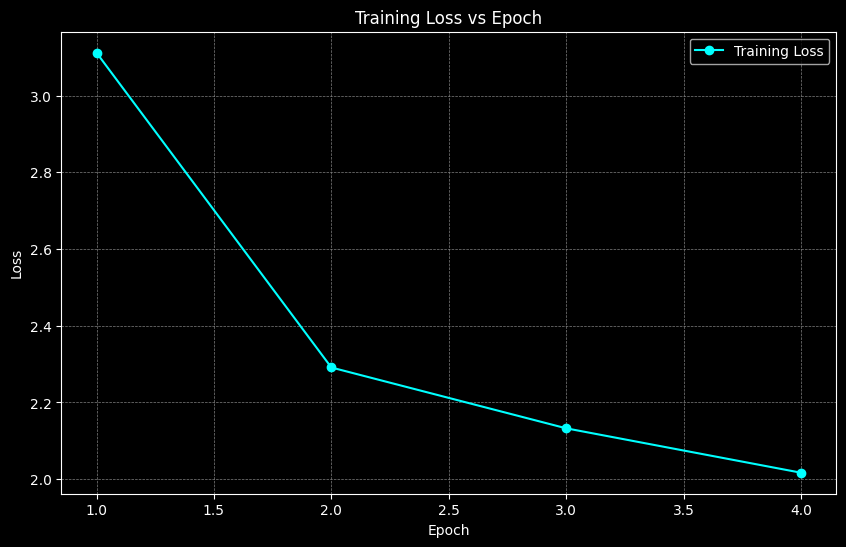

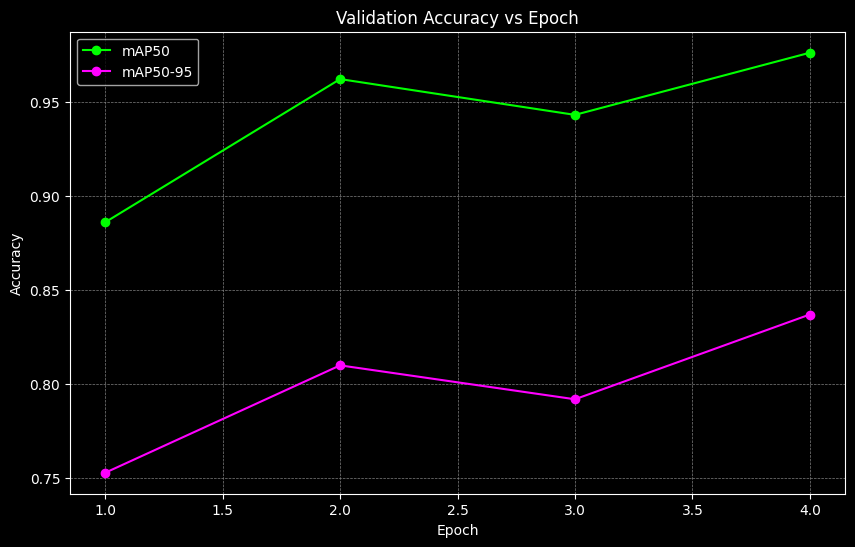

In [ ]:
import matplotlib.pyplot as plt

# Extract relevant data
epochs = [1, 2, 3, 4]
train_loss = [0.8337 + 1.29 + 0.9881, 0.6876 + 0.6935 + 0.9099, 0.647 + 0.5902 + 0.8952, 0.6103 + 0.5223 + 0.884]
val_mAP50 = [0.886, 0.962, 0.943, 0.976]
val_mAP50_95 = [0.753, 0.81, 0.792, 0.837]

# Plot training loss
plt.figure(figsize=(10, 6))
plt.style.use('dark_background')  # Black background style
plt.plot(epochs, train_loss, label='Training Loss', color='cyan', marker='o')
plt.xlabel('Epoch', color='white')
plt.ylabel('Loss', color='white')
plt.title('Training Loss vs Epoch', color='white')
plt.legend()
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 6))
plt.style.use('dark_background')  # Black background style
plt.plot(epochs, val_mAP50, label='mAP50', color='lime', marker='o')
plt.plot(epochs, val_mAP50_95, label='mAP50-95', color='magenta', marker='o')
plt.xlabel('Epoch', color='white')
plt.ylabel('Accuracy', color='white')
plt.title('Validation Accuracy vs Epoch', color='white')
plt.legend()
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()


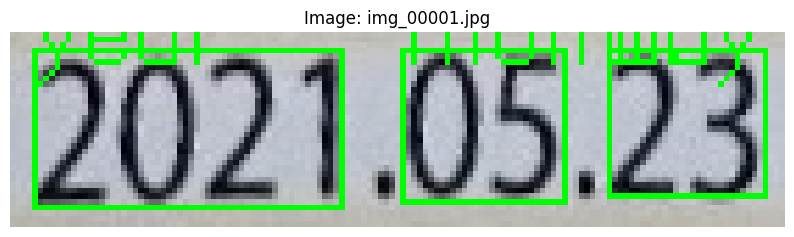

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Paths
test_images_path = '/content/DMY-Detection/test/images'
test_labels_path = '/content/DMY-Detection/test/labels'

# Class names
class_names = ['day', 'month', 'year']

# Load the first image and its corresponding label file
first_image_name = sorted(os.listdir(test_images_path))[0]
image_path = os.path.join(test_images_path, first_image_name)
label_path = os.path.join(test_labels_path, first_image_name.replace('.jpg', '.txt'))

# Read the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)

# Get image dimensions
height, width, _ = image.shape

# Read the labels and plot bounding boxes
if os.path.exists(label_path):
    with open(label_path, 'r') as f:
        labels = f.readlines()

    for label in labels:
        class_id, x_center, y_center, box_width, box_height = map(float, label.split())
        class_id = int(class_id)

        # Convert normalized YOLO bbox coordinates to pixel coordinates
        x_center *= width
        y_center *= height
        box_width *= width
        box_height *= height

        # Get top-left corner coordinates
        x1 = int(x_center - box_width / 2)
        y1 = int(y_center - box_height / 2)
        x2 = int(x_center + box_width / 2)
        y2 = int(y_center + box_height / 2)

        # Draw rectangle and label
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 0)
        cv2.putText(image, class_names[class_id], (x1, y1+2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.title(f"Image: {first_image_name}")
plt.show()


NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

##Component-Read

###Training PaddleOCR

In [ ]:
# import json
# import os

# annotations_path = os.path.join('/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Components-Real/Components-Real', 'annotations.json')
# with open(annotations_path, 'r') as f:
#     annotations = json.load(f)

# print("Keys in the JSON file:", annotations.keys())
# print(json.dumps(annotations, indent=4))  # Pretty print the JSON file


In [ ]:
# #COMPONENTS REAL
# import os
# import cv2
# import json
# import matplotlib.pyplot as plt

# # Paths to images and annotations
# images_dir = '/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Components-Real/Components-Real/images'
# annotations_path = '/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Components-Real/Components-Real/annotations.json'

# # Load the annotations
# with open(annotations_path, 'r') as f:
#     annotations = json.load(f)

# # Visualize images with annotations
# for image_name, annotation in annotations.items():
#     image_path = os.path.join(images_dir, image_name)

#     # Check if the image exists
#     if not os.path.exists(image_path):
#         print(f"Image {image_name} not found in {images_dir}")
#         continue

#     # Load the image
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # Extract transcription and dimensions
#     transcription = annotation.get("transcription", "")
#     height = annotation.get("height", image.shape[0])
#     width = annotation.get("width", image.shape[1])

#     # Display the image and annotation
#     plt.imshow(image)
#     plt.title(f"Transcription: {transcription}, Dimensions: {width}x{height}")
#     plt.axis('off')
#     plt.show()

#     # Stop after visualizing 5 images
#     if len(annotations) > 5:
#         break


In [ ]:
# !rm -rf /content/paddleocr_training_data.txt
# %cd /content
# import os
# import json

# # Paths
# images_dir = "/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Components-Real/Components-Real/images"
# annotations_path = "/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Components-Real/Components-Real/annotations.json"
# output_file = "/content/paddleocr_training_data.txt"

# # Load annotations
# with open(annotations_path, "r") as f:
#     annotations = json.load(f)

# # Open the output file to write data
# with open(output_file, "w") as f_out:
#     for item in annotations:
#         image_name = item  # Adjust key based on JSON structure
#         transcription = annotations[item]['transcription']  # Adjust key based on JSON structure
#         # Create the line in PaddleOCR format
#         image_path = os.path.join(images_dir, image_name)
#         line = f"{image_path}\t{transcription}\n"
#         f_out.write(line)

# print(f"Training data saved to {output_file}")


In [ ]:
# import os
# import json
# import random
# import shutil

# # Paths
# images_dir = "/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Components-Real/Components-Real/images"
# annotations_path = "/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Components-Real/Components-Real/annotations.json"
# train_images_dir = "/content/train_images"
# test_images_dir = "/content/test_images"
# train_annotations_path = "/content/train_annotations.json"
# test_annotations_path = "/content/test_annotations.json"

# # Split ratio
# train_ratio = 0.8  # 80% train, 20% test

# # Load annotations
# with open(annotations_path, "r") as f:
#     annotations = json.load(f)

# # Shuffle the data

# # Split data
# split_index = int(len(annotations) * train_ratio)
# train_data = annotations[:split_index]
# test_data = annotations[split_index:]

# # Ensure directories exist
# os.makedirs(train_images_dir, exist_ok=True)
# os.makedirs(test_images_dir, exist_ok=True)

# # Move images and save annotations
# def save_images_and_annotations(data, images_dir, target_images_dir, output_annotations_path):
#     annotations_to_save = []
#     for item in data:
#         image_name = item  # Adjust key based on JSON structure
#         source_path = os.path.join(images_dir, image_name)
#         target_path = os.path.join(target_images_dir, image_name)

#         # Copy the image to the target directory
#         if os.path.exists(source_path):  # Ensure the image exists
#             shutil.copy(source_path, target_path)
#             annotations_to_save.append(annotations[item]['transcription'])


#     with open(output_annotations_path, "w") as f_out:
#           for
#     #     json.dump(annotations_to_save, f_out, indent=4)

# # Save training images and annotations
# save_images_and_annotations(train_data, images_dir, train_images_dir, train_annotations_path)

# # Save testing images and annotations
# save_images_and_annotations(test_data, images_dir, test_images_dir, test_annotations_path)

# print(f"Training images and annotations saved to {train_images_dir} and {train_annotations_path}")
# print(f"Testing images and annotations saved to {test_images_dir} and {test_annotations_path}")


##Final Pipeline
To run this, download the <a href="https://drive.google.com/file/d/1H6CIoQAvDFw1x3HK-3b4XNXVfK9gM8rj/view?usp=sharing">Best_For_DMY.pt</a> and <a href = "https://drive.google.com/file/d/1X94W9wOTB8j0GIWkyEzh_Zic_AT_AgUR/view?usp=sharing">Best_For_Date.pt </a>

In [ ]:
!pip install paddleocr
!pip install paddlepaddle-gpu  # For GPU support

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.7/544.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 77.8 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=62c4783e92c0c4f171a3545201b0609e1743d090150f8f57015c65bb90fc1db5
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
   

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 12.1 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from paddleocr import PaddleOCR

# Load YOLOv8 models
date_model = YOLO("Best_For_Date.pt")
dmy_classifier = YOLO("Best_For_DMY.pt")

# Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang="en")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.10/dist-packages/paddle/base/framework.py:688: UserWarning: You are using GPU version Paddle, but your CUDA device is not set properly. CPU device will be used by default.
  warnings.warn(


download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3910/3910 [00:15<00:00, 250.20it/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10000/10000 [00:18<00:00, 544.08it/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:09<00:00, 228.14it/s]

[2024/12/11 08:30:49] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

In [ ]:
import cv2
import numpy as np

def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    # Compute the intersection coordinates
    inter_x1 = max(x1, x1_)
    inter_y1 = max(y1, y1_)
    inter_x2 = min(x2, x2_)
    inter_y2 = min(y2, y2_)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_ - x1_) * (y2_ - y1_)

    # Compute the union area
    union_area = box1_area + box2_area - inter_area

    # Compute IoU
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

def filter_overlapping_boxes(boxes):
    filtered_boxes = []
    boxes = sorted(boxes, key=lambda x: x[4], reverse=True)  # Sort by confidence

    while boxes:
        best_box = boxes.pop(0)
        filtered_boxes.append(best_box)
        boxes = [box for box in boxes if compute_iou(best_box[:4], box[:4]) <= 0.5]

    return filtered_boxes

def extract_date_regions(image_path):
    # Step 1: Detect all regions with best_for_date
    image = cv2.imread(image_path)
    results = date_model(image)

    if len(results[0].boxes) == 0:
        return "No regions detected"

    # Step 2: Process each detected region
    detected_boxes = []
    for box in results[0].boxes.data:
        x1, y1, x2, y2, confidence, class_id = box.cpu().numpy()
        category = class_map[int(class_id)]
        if confidence < 0.5:
            continue
        detected_boxes.append([x1, y1, x2, y2, confidence, category])

    # Filter overlapping boxes
    filtered_boxes = filter_overlapping_boxes(detected_boxes)

    detected_dates = []
    for x1, y1, x2, y2, confidence, category in filtered_boxes:
        if category == 'date':
            # Crop and process the date region
            region = image[int(y1):int(y2), int(x1):int(x2)]
            cv2_imshow(region)
            # Step 3: Classify day, month, year sub-regions
            dmy_results = dmy_classifier(region)
            if len(dmy_results[0].boxes) < 1:
                continue  # Skip if DMY regions are not properly detected

            # Extract day, month, year regions dynamically based on category prediction
            dmy_boxes = dmy_results[0].boxes.data
            dmy_dict = {"day": None, "month": None, "year": None}
            dmy_class = {0: "day", 1: "month", 2: "year"}
            date_conf, month_conf, year_conf = -1, -1, -1

            for boxo in dmy_boxes:
                x1_, y1_, x2_, y2_, confidence_, class_id_ = boxo.cpu().numpy()
                class_name = dmy_class[int(class_id_)]

                cropped_region = region[int(y1_):int(y2_), int(x1_):int(x2_)]

                if class_name == "day" and confidence_ > date_conf:
                    date_conf = confidence_
                    dmy_dict["day"] = cropped_region
                elif class_name == "month" and confidence_ > month_conf:
                    month_conf = confidence_
                    dmy_dict["month"] = cropped_region
                elif class_name == "year" and confidence_ > year_conf:
                    year_conf = confidence_
                    dmy_dict["year"] = cropped_region

            # Display each region using cv2_imshow
            for category, cropped_region in dmy_dict.items():
                if cropped_region is not None:
                    cv2_imshow(cropped_region)
                    print(f"Displaying {category} region:")

            # OCR extraction
            def ocr_extract(region):
                result = ocr.ocr(region, cls=True)
                text = result[0][1][0] if result and result[0] else ""
                return text.strip().upper()


            day = 1
            month = 1
            year = 1
            try:
              day = ocr_extract(dmy_dict["day"]) if dmy_dict["day"] is not None else "1"
            except:
              day = 1
            try:
              month = ocr_extract(dmy_dict["month"]) if dmy_dict["month"] is not None else "1"
            except:
              month = 1

            try:
              year = ocr_extract(dmy_dict["year"]) if dmy_dict["year"] is not None else ""
            except:
              year = 1

            if month in month_map:
                month = month_map[month]

            try:
                formatted_date = f"{year}-{month.zfill(2)}-{day.zfill(2)}"
                detected_dates.append({
                    "category": category,
                    "formatted_date": formatted_date,
                    "bounding_box": [int(x1), int(y1), int(x2), int(y2)]
                })
            except Exception as e:
                detected_dates.append({
                    "category": category,
                    "error": f"Error formatting date: {e}",
                    "bounding_box": [int(x1), int(y1), int(x2), int(y2)]
                })
        else:
            detected_dates.append({
                "category": category,
                "bounding_box": [int(x1), int(y1), int(x2), int(y2)]
            })

    return detected_dates

# Example usage
image_path = "download.png"    #Change the name of File Uploaded
output = extract_date_regions(image_path)
print("Detected Regions and Dates:", output)



0: 416x640 3 codes, 3 dates, 2 dues, 1 prod, 202.2ms
Speed: 5.2ms preprocess, 202.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



0: 128x640 1 day, 1 month, 1 year, 75.1ms
Speed: 1.4ms preprocess, 75.1ms inference, 1.3ms postprocess per image at shape (1, 3, 128, 640)


Displaying day region:


Displaying month region:


Displaying year region:
[2024/12/11 09:14:09] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.024478435516357422
[2024/12/11 09:14:09] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/12/11 09:14:09] ppocr DEBUG: rec_res num  : 0, elapsed : 2.86102294921875e-06
[2024/12/11 09:14:09] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.024123191833496094
[2024/12/11 09:14:09] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/12/11 09:14:09] ppocr DEBUG: rec_res num  : 0, elapsed : 2.384185791015625e-06
[2024/12/11 09:14:09] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.020259857177734375
[2024/12/11 09:14:09] ppocr DEBUG: cls num  : 1, elapsed : 0.0158388614654541
[2024/12/11 09:14:09] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0777587890625



0: 128x640 1 day, 1 month, 1 year, 79.8ms
Speed: 4.3ms preprocess, 79.8ms inference, 0.9ms postprocess per image at shape (1, 3, 128, 640)


Displaying day region:


Displaying month region:


Displaying year region:
[2024/12/11 09:14:09] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.018080949783325195
[2024/12/11 09:14:09] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/12/11 09:14:09] ppocr DEBUG: rec_res num  : 0, elapsed : 2.86102294921875e-06
[2024/12/11 09:14:09] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.018269777297973633
[2024/12/11 09:14:09] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/12/11 09:14:09] ppocr DEBUG: rec_res num  : 0, elapsed : 2.384185791015625e-06
[2024/12/11 09:14:09] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.026560544967651367
[2024/12/11 09:14:09] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/12/11 09:14:09] ppocr DEBUG: rec_res num  : 0, elapsed : 2.86102294921875e-06



0: 128x640 1 day, 1 month, 1 year, 86.3ms
Speed: 1.6ms preprocess, 86.3ms inference, 1.2ms postprocess per image at shape (1, 3, 128, 640)


Displaying day region:


Displaying month region:


Displaying year region:
[2024/12/11 09:14:10] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.020736217498779297
[2024/12/11 09:14:10] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/12/11 09:14:10] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06
[2024/12/11 09:14:10] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.022136926651000977
[2024/12/11 09:14:10] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/12/11 09:14:10] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06
[2024/12/11 09:14:10] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.021045446395874023
[2024/12/11 09:14:10] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/12/11 09:14:10] ppocr DEBUG: rec_res num  : 0, elapsed : 2.6226043701171875e-06
Detected Regions and Dates: [{'category': 'code', 'bounding_box': [217, 143, 261, 158]}, {'category': 'year', 'formatted_date': '1-00-00', 'bounding_box': [103, 143, 193, 158]}, {'category': 'year', 'formatted_date': '-00-00', 'bounding_box': [104, 91, 193, 105]}, {'category': 'year

##Auxilary

In [ ]:
#COMPONENTS SYNTH
import os
import cv2
import json
import matplotlib.pyplot as plt

# Paths to images and annotations
images_dir = '/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Components-Synth/Components-Synth/images'
annotations_path = '/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Components-Synth/Components-Synth/annotations.json'

# Load the annotations
with open(annotations_path, 'r') as f:
    annotations = json.load(f)

# Visualize images with annotations
for image_name, annotation in annotations.items():
    image_path = os.path.join(images_dir, image_name)

    # Check if the image exists
    if not os.path.exists(image_path):
        print(f"Image {image_name} not found in {images_dir}")
        continue

    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract transcription and dimensions
    transcription = annotation.get("transcription", "")
    height = annotation.get("height", image.shape[0])
    width = annotation.get("width", image.shape[1])

    # Display the image and annotation
    plt.imshow(image)
    plt.title(f"Transcription: {transcription}, Dimensions: {width}x{height}")
    plt.axis('off')
    plt.show()

    # Stop after visualizing 5 images
    if len(annotations) > 5:
        break


In [ ]:
#DATA REAL
import os
import cv2
import json
import matplotlib.pyplot as plt

# Paths to images and annotations
images_dir = '/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Date-Real/Date-Real/images'
annotations_path = '/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Date-Real/Date-Real/annotations.json'

# Load the annotations
with open(annotations_path, 'r') as f:
    annotations = json.load(f)

# Visualize images with annotations
for image_name, annotation in annotations.items():
    image_path = os.path.join(images_dir, image_name)

    # Check if the image exists
    if not os.path.exists(image_path):
        print(f"Image {image_name} not found in {images_dir}")
        continue

    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract transcription and dimensions
    transcription = annotation.get("transcription", "")
    height = annotation.get("height", image.shape[0])
    width = annotation.get("width", image.shape[1])

    # Display the image and annotation
    plt.imshow(image)
    plt.title(f"Transcription: {transcription}, Dimensions: {width}x{height}")
    plt.axis('off')
    plt.show()

    # Stop after visualizing 5 images
    if len(annotations) > 5:
        break


In [ ]:
#DATA SYNTH

import os
import cv2
import json
import matplotlib.pyplot as plt

# Paths to images and annotations
images_dir = '/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Date-Synth/Date-Synth/images'
annotations_path = '/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Date-Synth/Date-Synth/annotations.json'

# Load the annotations
with open(annotations_path, 'r') as f:
    annotations = json.load(f)

# Visualize images with annotations
for image_name, annotation in annotations.items():
    image_path = os.path.join(images_dir, image_name)

    # Check if the image exists
    if not os.path.exists(image_path):
        print(f"Image {image_name} not found in {images_dir}")
        continue

    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract transcription and dimensions
    transcription = annotation.get("transcription", "")
    height = annotation.get("height", image.shape[0])
    width = annotation.get("width", image.shape[1])

    # Display the image and annotation
    plt.imshow(image)
    plt.title(f"Transcription: {transcription}, Dimensions: {width}x{height}")
    plt.axis('off')
    plt.show()

    # Stop after visualizing 5 images
    if len(annotations) > 5:
        break


In [ ]:
#PRODUCTS SYNTH

import os
import cv2
import json
import matplotlib.pyplot as plt

# Paths to images and annotations
images_dir = '/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Products-Synth/Products-Synth/images'
annotations_path = '/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Products-Synth/Products-Synth/annotations.json'

# Load the annotations
with open(annotations_path, 'r') as f:
    annotations = json.load(f)

# Visualize images with annotations
for image_name, annotation in annotations.items():
    image_path = os.path.join(images_dir, image_name)

    # Check if the image exists
    if not os.path.exists(image_path):
        print(f"Image {image_name} not found in {images_dir}")
        continue

    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract transcription and dimensions
    transcription = annotation.get("transcription", "")
    height = annotation.get("height", image.shape[0])
    width = annotation.get("width", image.shape[1])

    # Display the image and annotation
    plt.imshow(image)
    plt.title(f"Transcription: {transcription}, Dimensions: {width}x{height}")
    plt.axis('off')
    plt.show()

    # Stop after visualizing 5 images
    if len(annotations) > 5:
        break


In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),          # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


In [ ]:
from sklearn.model_selection import train_test_split

# Split image names and annotations
image_names = list(annotations.keys())
train_names, test_names = train_test_split(image_names, test_size=0.15, random_state=42)
train_names, val_names = train_test_split(train_names, test_size=0.15, random_state=42)

# Filter annotations for each split
train_annotations = {name: annotations[name] for name in train_names}
val_annotations = {name: annotations[name] for name in val_names}
test_annotations = {name: annotations[name] for name in test_names}


In [ ]:
from torch.utils.data import Dataset, DataLoader

class ExpiryDataset(Dataset):
    def __init__(self, images_dir, annotations, transform=None):
        self.images_dir = images_dir
        self.annotations = annotations
        self.image_names = list(annotations.keys())
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.images_dir, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        annotation = self.annotations[image_name]
        transcription = annotation.get("transcription", "")

        if self.transform:
            image = self.transform(image)

        return image, transcription

# Instantiate datasets
train_dataset = ExpiryDataset('/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Components-Real/Components-Real/images', train_annotations, transform=transform)
val_dataset = ExpiryDataset('/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Components-Real/Components-Real/images', val_annotations, transform=transform)
test_dataset = ExpiryDataset('/content/Expiry-Date-Dataset/Expiry_Date_Dataset/Components-Real/Components-Real/images', test_annotations, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import FCOS

# Define Date Detection Model
def create_date_detection_model(num_classes):
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)
    model = FCOS(backbone, num_classes=num_classes)
    return model

model_date = create_date_detection_model(num_classes=2)  # 1 class + background


In [ ]:
def create_dmy_detection_model(num_classes):
    backbone = resnet_fpn_backbone('resnet34', pretrained=True)
    model = FCOS(backbone, num_classes=num_classes)
    return model

model_dmy = create_dmy_detection_model(num_classes=4)  # Day, Month, Year + Background


In [ ]:
import torch.nn as nn

class CRNN(nn.Module):
    def __init__(self, img_height, num_classes):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.rnn = nn.LSTM(128 * (img_height // 4), 256, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(256 * 2, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 3, 1, 2)  # Prepare for RNN
        x = x.contiguous().view(x.size(0), x.size(1), -1)
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x

model_crnn = CRNN(img_height=32, num_classes=37)  # 36 chars + blank


In [ ]:
# Detect date regions
date_regions = model_date(frame)

# Detect DMY components within each date region
for region in date_regions:
    dmy_components = model_dmy(region)

    # Recognize characters in each component
    for comp in dmy_components:
        recognized_text = model_crnn(comp)
        print("Recognized Text:", recognized_text)
